In [31]:
import pandas as pd 
import numpy as np
import pycatch22 as tsfe
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Get Earnings Number to Homogenize Dates across Tickers

In [2]:
df_actual_est = pd.read_csv('ActualEarningsData20182022.csv').sort_values(['TICKER', 'ANNDATS'], ascending=[True, False]).set_index('TICKER')
df_actual_est.head()

,OFTIC,CUSIP,CNAME,PENDS,MEASURE,PDICITY,ANNDATS,VALUE
TICKER,,,,,,,,
0045,PE,70187710,PARSLEY EGY,20200930,EPS,QTR,20201028,0.22
0045,PE,70187710,PARSLEY EGY,20200630,EPS,QTR,20200805,0.03
0045,PE,70187710,PARSLEY EGY,20200331,EPS,QTR,20200504,0.29
0045,PE,70187710,PARSLEY EGY,20191231,EPS,QTR,20200219,0.28
0045,PE,70187710,PARSLEY EGY,20190930,EPS,QTR,20191105,0.29


In [3]:
df_actual_est['ERNUM'] = df_actual_est.groupby(
    'TICKER', 
    group_keys = False
).apply(
    lambda x: (x.ANNDATS != x.ANNDATS.shift(1)).cumsum()[::-1]
)
max_ernum = df_actual_est.ERNUM.max()
df_actual_est['ERNUM'] = df_actual_est.ERNUM.groupby(
    'TICKER', 
    group_keys=False
).apply(
    lambda x: x + (max_ernum - x.max())
)

In [4]:
df_actual_est

,OFTIC,CUSIP,CNAME,PENDS,MEASURE,PDICITY,ANNDATS,VALUE,ERNUM
TICKER,,,,,,,,,
0045,PE,70187710,PARSLEY EGY,20200930,EPS,QTR,20201028,0.22,20
0045,PE,70187710,PARSLEY EGY,20200630,EPS,QTR,20200805,0.03,19
0045,PE,70187710,PARSLEY EGY,20200331,EPS,QTR,20200504,0.29,18
0045,PE,70187710,PARSLEY EGY,20191231,EPS,QTR,20200219,0.28,17
0045,PE,70187710,PARSLEY EGY,20190930,EPS,QTR,20191105,0.29,16
...,...,...,...,...,...,...,...,...,...
ZYNE,ZYNE,98986X10,ZYNERBA PHARMS,20181231,EPS,QTR,20190311,-0.44,6
ZYNE,ZYNE,98986X10,ZYNERBA PHARMS,20180930,EPS,QTR,20181108,-0.47,5
ZYNE,ZYNE,98986X10,ZYNERBA PHARMS,20180630,EPS,QTR,20180802,-0.89,4


# Try Homogenizing Dates for Estimates

In [5]:
actual_est = df_actual_est.set_index('ANNDATS', append=True)
actual_est.head()

OFTIC     CUSIP        CNAME     PENDS MEASURE PDICITY  VALUE  \
TICKER ANNDATS                                                                  
0045   20201028    PE  70187710  PARSLEY EGY  20200930     EPS     QTR   0.22   
       20200805    PE  70187710  PARSLEY EGY  20200630     EPS     QTR   0.03   
       20200504    PE  70187710  PARSLEY EGY  20200331     EPS     QTR   0.29   
       20200219    PE  70187710  PARSLEY EGY  20191231     EPS     QTR   0.28   
       20191105    PE  70187710  PARSLEY EGY  20190930     EPS     QTR   0.29   

                 ERNUM  
TICKER ANNDATS          
0045   20201028     20  
       20200805     19  
       20200504     18  
       20200219     17  
       20191105     16

In [6]:
df_estimates = pd.read_csv('InitialEstimatesData20182022.csv')
df_estimates = df_estimates[df_estimates.FISCALP == 'QTR']
df_estimates.FPEDATS = df_estimates.FPEDATS.astype('int')
estimates = df_estimates.set_index(['TICKER', 'FPEDATS'])

In [7]:
estimates = estimates.loc[estimates.index.get_level_values(0).isin(actual_est.index.get_level_values(0))].sort_index()
estimates['ERNUM'] = 0
estimates.head()

OFTIC     CUSIP               CNAME  STATPERS MEASURE FISCALP  \
TICKER FPEDATS                                                                  
0045   20171231    PE  70187710  PARSLEY ENERGY INC  20180118     EPS     QTR   
       20171231    PE  70187710  PARSLEY ENERGY INC  20180215     EPS     QTR   
       20180331    PE  70187710  PARSLEY ENERGY INC  20180315     EPS     QTR   
       20180331    PE  70187710  PARSLEY ENERGY INC  20180419     EPS     QTR   
       20180331    PE  70187710  PARSLEY ENERGY INC  20180118     EPS     QTR   

                 FPI ESTFLAG  NUMEST  NUMUP  NUMDOWN  MEDEST  MEANEST  STDEV  \
TICKER FPEDATS                                                                 
0045   20171231    6       P      30     13        1    0.18     0.19   0.04   
       20171231    6       P      31      6       18    0.17     0.17   0.03   
       20180331    6       P      29     13       10    0.22     0.22   0.06   
       20180331    6       P      30      9        6    0.24     0.23   0.04   
       20180331    7       P      27     10        0    0.21     0.23   0.07   

                 HIGHEST  LOWEST  ERNUM  
TICKER FPEDATS                           
0045   20171231     0.26    0.09      0  
       20171231     0.25    0.09      0  
       20180331     0.33    0.13      0  
       20180331     0.31    0.13      0  
       20180331     0.38    0.12      0

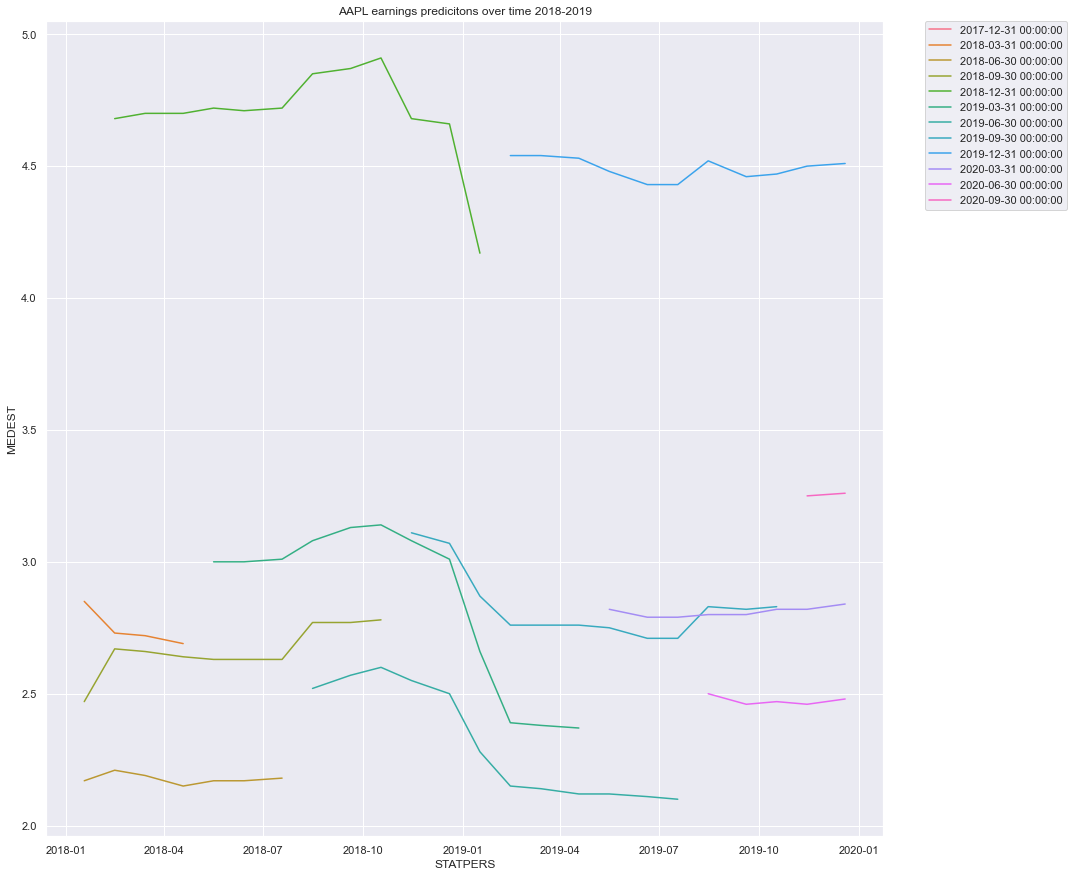

In [32]:
est_graph = estimates.reset_index()
est_graph = est_graph[est_graph.OFTIC == 'AAPL']
est_graph = est_graph[est_graph.STATPERS < 20200101]
est_graph.STATPERS = pd.to_datetime(est_graph.STATPERS, format="%Y%m%d")
est_graph.FPEDATS = pd.to_datetime(est_graph.FPEDATS, format="%Y%m%d")

# est_graph.plot(kind='scatter',x='STATPERS',y='MEDEST',color='FPEDATS')
sns.set(rc={'figure.figsize':(15,15)})
sns.lineplot(data=est_graph, x='STATPERS', y='MEDEST', hue='FPEDATS').set_title("AAPL earnings predicitons over time 2018-2019")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [8]:
for idx, row in actual_est.iterrows():
    try:
        estimates.loc[
            (
                idx[0], 
                slice(idx[1])
            ),
            'ERNUM'
        ] = row.ERNUM
    except:
        pass

In [9]:
estimates = estimates.droplevel(1).set_index('ERNUM', append=True).sort_index()
estimates.head()

OFTIC     CUSIP               CNAME  STATPERS MEASURE FISCALP  \
TICKER ERNUM                                                                 
0045   0        PE  70187710  PARSLEY ENERGY INC  20201119     EPS     QTR   
       0        PE  70187710  PARSLEY ENERGY INC  20201217     EPS     QTR   
       0        PE  70187710  PARSLEY ENERGY INC  20200820     EPS     QTR   
       0        PE  70187710  PARSLEY ENERGY INC  20200917     EPS     QTR   
       0        PE  70187710  PARSLEY ENERGY INC  20201015     EPS     QTR   

              FPI ESTFLAG  NUMEST  NUMUP  NUMDOWN  MEDEST  MEANEST  STDEV  \
TICKER ERNUM                                                                
0045   0        6       P      26      9       10    0.28     0.24   0.12   
       0        6       P      26      5        1    0.29     0.25   0.13   
       0        7       P      28     20        3    0.28     0.21   0.14   
       0        7       P      28     11        2    0.28     0.24   0.12   
       0        7       P      27      5        5    0.28     0.24   0.11   

              HIGHEST  LOWEST  
TICKER ERNUM                   
0045   0         0.47    0.01  
       0         0.47    0.01  
       0         0.42   -0.04  
       0         0.45    0.00  
       0         0.44    0.04

In [31]:
estimates.sort_index(inplace=True)
estimates

OFTIC     CUSIP                        CNAME  STATPERS MEASURE  \
TICKER ERNUM                                                                  
0045   0        PE  70187710           PARSLEY ENERGY INC  20201119     EPS   
       0        PE  70187710           PARSLEY ENERGY INC  20201217     EPS   
       0        PE  70187710           PARSLEY ENERGY INC  20200820     EPS   
       0        PE  70187710           PARSLEY ENERGY INC  20200917     EPS   
       0        PE  70187710           PARSLEY ENERGY INC  20201015     EPS   
...            ...       ...                          ...       ...     ...   
ZYNE   20     ZYNE  98986X10  ZYNERBA PHARMACEUTICALS INC  20220120     EPS   
       20     ZYNE  98986X10  ZYNERBA PHARMACEUTICALS INC  20220217     EPS   
       20     ZYNE  98986X10  ZYNERBA PHARMACEUTICALS INC  20210819     EPS   
       20     ZYNE  98986X10  ZYNERBA PHARMACEUTICALS INC  20210916     EPS   
       20     ZYNE  98986X10  ZYNERBA PHARMACEUTICALS INC  20211014     EPS   

             FISCALP  FPI ESTFLAG  NUMEST  NUMUP  NUMDOWN  MEDEST  MEANEST  \
TICKER ERNUM                                                                 
0045   0         QTR    6       P      26      9       10    0.28     0.24   
       0         QTR    6       P      26      5        1    0.29     0.25   
       0         QTR    7       P      28     20        3    0.28     0.21   
       0         QTR    7       P      28     11        2    0.28     0.24   
       0         QTR    7       P      27      5        5    0.28     0.24   
...              ...  ...     ...     ...    ...      ...     ...      ...   
ZYNE   20        QTR    8       P       3      1        0   -0.26    -0.26   
       20        QTR    8       P       3      0        0   -0.26    -0.26   
       20        QTR    9       P       2      0        1   -0.28    -0.28   
       20        QTR    9       P       2      0        0   -0.28    -0.28   
       20        QTR    9       P       2      0        0   -0.28    -0.28   

              STDEV  HIGHEST  LOWEST  
TICKER ERNUM                          
0045   0       0.12     0.47    0.01  
       0       0.13     0.47    0.01  
       0       0.14     0.42   -0.04  
       0       0.12     0.45    0.00  
       0       0.11     0.44    0.04  
...             ...      ...     ...  
ZYNE   20      0.04    -0.22   -0.29  
       20      0.04    -0.22   -0.29  
       20      0.06    -0.24   -0.32  
       20      0.06    -0.24   -0.32  
       20      0.06    -0.24   -0.32  

[297091 rows x 16 columns]

# Time Series Feature Extraction for AAPL

In [11]:
est_appl = estimates.loc['AAPL']
est_appl.reset_index(inplace=True)
est_appl.set_index(['OFTIC', 'ERNUM'], inplace=True)
est_appl

CUSIP      CNAME  STATPERS MEASURE FISCALP  FPI ESTFLAG  \
OFTIC ERNUM                                                               
AAPL  0      03783310  APPLE INC  20220818     EPS     QTR    6       P   
      0      03783310  APPLE INC  20220915     EPS     QTR    6       P   
      0      03783310  APPLE INC  20220519     EPS     QTR    7       P   
      0      03783310  APPLE INC  20220616     EPS     QTR    7       P   
      0      03783310  APPLE INC  20220714     EPS     QTR    7       P   
...               ...        ...       ...     ...     ...  ...     ...   
      20     03783310  APPLE INC  20211216     EPS     QTR    8       P   
      20     03783310  APPLE INC  20220120     EPS     QTR    8       P   
      20     03783310  APPLE INC  20210819     EPS     QTR    9       P   
      20     03783310  APPLE INC  20210916     EPS     QTR    9       P   
      20     03783310  APPLE INC  20211014     EPS     QTR    9       P   

             NUMEST  NUMUP  NUMDOWN  MEDEST  MEANEST  STDEV  HIGHEST  LOWEST  
OFTIC ERNUM                                                                   
AAPL  0          27      4       22    1.26     1.26   0.05     1.35    1.13  
      0          27      3        1    1.26     1.26   0.04     1.35    1.13  
      0          28      4       22    1.32     1.33   0.06     1.45    1.21  
      0          28      0        2    1.32     1.32   0.06     1.44    1.21  
      0          28      1        6    1.30     1.31   0.06     1.44    1.22  
...             ...    ...      ...     ...      ...    ...      ...     ...  
      20         24      1        1    1.18     1.18   0.08     1.40    0.98  
      20         26      2        4    1.18     1.18   0.08     1.40    0.98  
      20         22     17        1    1.18     1.18   0.09     1.29    0.95  
      20         22      2        1    1.18     1.18   0.09     1.29    0.95  
      20         22      1        1    1.18     1.18   0.09     1.29    0.95  

[228 rows x 15 columns]

In [12]:
ret, col = [], 'MEDEST'
for ticker, ernum in est_appl.index.unique():
    ftrs = pd.DataFrame(tsfe.catch22_all(est_appl.loc[(ticker, ernum), col])).set_index('names').T
    ftrs.columns.name = None
    ftrs['ticker'] = ticker
    ftrs['ernum'] = ernum
    ftrs.set_index(['ticker', 'ernum'], inplace=True)
    ret.append(ftrs)

    all_ftrs = pd.concat(ret).add_prefix(col)


In [13]:
all_ftrs = pd.concat(ret).add_prefix(col)
all_ftrs.head()

MEDESTDN_HistogramMode_5  MEDESTDN_HistogramMode_10  \
ticker ernum                                                        
AAPL   0                     -0.675667                  -0.801185   
       2                           NaN                        NaN   
       3                     -0.589359                  -0.021302   
       4                     -0.483795                  -0.325049   
       5                     -0.430636                  -0.263765   

              MEDESTCO_f1ecac  MEDESTCO_FirstMin_ac  \
ticker ernum                                          
AAPL   0             3.476958                   8.0   
       2             0.000000                   0.0   
       3             0.502655                   1.0   
       4             0.773574                   2.0   
       5             0.956340                   3.0   

              MEDESTCO_HistogramAMI_even_2_5  MEDESTCO_trev_1_num  \
ticker ernum                                                        
AAPL   0                            0.505602             0.062378   
       2                                 NaN                  NaN   
       3                            0.000000             3.883793   
       4                            1.332179            -0.888972   
       5                            0.562335            -1.141338   

              MEDESTMD_hrv_classic_pnn40  \
ticker ernum                               
AAPL   0                        0.360000   
       2                             NaN   
       3                        1.000000   
       4                        0.833333   
       5                        0.666667   

              MEDESTSB_BinaryStats_mean_longstretch1  \
ticker ernum                                           
AAPL   0                                         9.0   
       2                                         NaN   
       3                                         1.0   
       4                                         4.0   
       5                                         3.0   

              MEDESTSB_TransitionMatrix_3ac_sumdiagcov  \
ticker ernum                                             
AAPL   0                                      0.062500   
       2                                           NaN   
       3                                      0.111111   
       4                                      0.111111   
       5                                      0.074074   

              MEDESTPD_PeriodicityWang_th0_01  ...  \
ticker ernum                                   ...   
AAPL   0                                  0.0  ...   
       2                                  0.0  ...   
       3                                  0.0  ...   
       4                                  0.0  ...   
       5                                  0.0  ...   

              MEDESTFC_LocalSimple_mean1_tauresrat  \
ticker ernum                                         
AAPL   0                                  0.500000   
       2                                       NaN   
       3                                  1.000000   
       4                                  0.500000   
       5                                  0.333333   

              MEDESTDN_OutlierInclude_p_001_mdrmd  \
ticker ernum                                        
AAPL   0                                 0.192308   
       2                                      NaN   
       3                                 1.000000   
       4                                 0.285714   
       5                                -0.600000   

              MEDESTDN_OutlierInclude_n_001_mdrmd  \
ticker ernum                                        
AAPL   0                                -0.461538   
       2                                      NaN   
       3                                 0.000000   
       4                                 0.142857   
       5                                 0.200000   

              MEDESTSP_Summaries_welch_rect_area_

In [24]:
def ts_features_extraction(et_tick):
    ret, col = [], 'MEDEST'
    for ticker, ernum in et_tick.index.unique():
        x = et_tick.loc[(ticker, ernum)]
        x.reset_index(inplace=True)
        x = list(x.MEDEST)
        if len(x) < 3:
            continue
        # print(x)
        ftrs = pd.DataFrame(tsfe.catch22_all(x)).set_index('names').T
        # ftrs = pd.DataFrame(tsfe.catch22_all(est_tick.loc[(ticker, ernum), col])).set_index('names').T
        ftrs.columns.name = None
        ftrs['ticker'] = ticker
        ftrs['ernum'] = ernum
        ftrs.set_index(['ticker', 'ernum'], inplace=True)
        ret.append(ftrs)

    return ret, col

In [35]:
all_ticks_features = list()
for tick in estimates.index.get_level_values('TICKER').unique():
    # print(tick)
    est_tick = estimates.loc[tick]
    est_tick.reset_index(inplace=True)
    est_tick = est_tick[['OFTIC', 'ERNUM', 'MEDEST']]
    est_tick.set_index(['OFTIC', 'ERNUM'], inplace=True)
    est_tick
    try:
        ret, col = ts_features_extraction(et_tick=est_tick)
    except:
        print(tick)
        continue
    all_ftrs = pd.concat(ret).add_prefix(col)
    all_ticks_features.append(all_ftrs)

AIG
ARCW


In [38]:
ftrs = pd.concat(all_ticks_features)
ftrs

MEDESTDN_HistogramMode_5  MEDESTDN_HistogramMode_10  \
ticker ernum                                                        
PE     0                      0.554717                   0.554717   
       10                    -0.278152                  -0.158944   
       11                    -0.944501                  -0.811606   
       12                     0.679041                   0.805375   
       13                     0.597099                   0.115855   
...                                ...                        ...   
ZYNE   16                    -0.877040                  -0.993608   
       17                     0.573158                   0.136466   
       18                    -0.784639                  -0.908530   
       19                     0.134067                  -0.026813   
       20                     0.927055                  -0.104667   

              MEDESTCO_f1ecac  MEDESTCO_FirstMin_ac  \
ticker ernum                                          
PE     0             0.947561                   3.0   
       10            0.425143                   1.0   
       11            1.225546                   3.0   
       12            1.719681                   6.0   
       13            0.773228                   3.0   
...                       ...                   ...   
ZYNE   16            1.716099                   9.0   
       17            1.256304                   5.0   
       18            0.858353                   3.0   
       19            0.760035                   2.0   
       20            1.814467                   3.0   

              MEDESTCO_HistogramAMI_even_2_5  MEDESTCO_trev_1_num  \
ticker ernum                                                        
PE     0                            0.177047             0.901438   
       10                           0.693147            -3.011568   
       11                           0.395753            -1.576923   
       12                           0.422870            -0.697476   
       13                           0.916291             0.085452   
...                                      ...                  ...   
ZYNE   16                           0.838699            -0.484466   
       17                           0.311239            -0.256298   
       18                           0.482057            -0.151262   
       19                           0.032189            -2.649787   
       20                           0.284181            -0.878003   

              MEDESTMD_hrv_classic_pnn40  \
ticker ernum                               
PE     0                        0.800000   
       10                       1.000000   
       11                       0.833333   
       12                       0.666667   
       13                       0.818182   
...                                  ...   
ZYNE   16                       0.363636   
       17                       0.454545   
       18                       0.545455   
       19                       0.363636   
       20                       0.363636   

              MEDESTSB_BinaryStats_mean_longstretch1  \
ticker ernum                                           
PE     0                                         6.0   
       10                                        2.0   
       11                                        3.0   
       12                                        6.0   
       13                                        4.0   
...                                              ...   
ZYNE   16                                        5.0   
       17                                        8.0   
       18                                        4.0   
       19                                        4.0   
       20                                        5.0   

              MEDESTSB_TransitionMatrix_3ac_sumdiagcov  \
ticker ernum                                             
PE     0                                      0.027778   
       10                 